# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import time
import torch
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, raw_weightTransformer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data

In [3]:
# df = pd.read_csv('new_cohort.csv')
#df = pd.read_csv('Elham_data')
#print(df.shape)
# df.head()

In [4]:
from dfply import *
from IPython.display import display
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine, event

conn_str = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=KVHSQLPC56;DATABASE=AHDA;Trusted_Connection=yes;'
conn_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_str})
engine = create_engine(conn_url)

# Query to get patient interactions after first fall
query = """WITH FirstFall AS (
       SELECT 
              Distinct patient_id
              ,min([admit_datetime]) as first_fall
              ,min(diagnosis_age) as first_fall_age
       FROM 
              Core.acute_care_diagnoses acd
       WHERE 
              diagnosis_type_code NOT IN ('3', '4', '0')
              AND SUBSTRING(icd10_code, 1, 3) IN ('W06', 'W07', 'W08', 'W13', 'W14', 'W15', 'W16', 'W17', 
                                      'X80', 'Y01', 'Y30', 'W00', 'W01', 'W03', 'W04', 'W18', 
                                      'W10', 'W05')
              AND diagnosis_age >= 65
       GROUP BY 
              patient_id
)
SELECT 
       i.patient_id, i.service_class_id, i.start_datetime, i.end_datetime
FROM 
       FirstFall
INNER JOIN 
       HF.interactions i ON i.patient_id = FirstFall.patient_id
WHERE 
       i.start_datetime < first_fall
AND        
        i.service_class_id NOT IN (80,150,152,68)
ORDER BY i.patient_id, i.start_datetime"""

df = pd.read_sql(query, engine)
df = df[df['service_class_id'].notna()]
unique_patients = df['patient_id'].unique()
       
df = df[df['patient_id'].isin(unique_patients)]
print(df.shape)

(144090, 4)


# Data To Raw_Weight

In [5]:
def generate_raw_weight_matrix(interactions_df):
    # Aggregate service class IDs per patient
    interactions_df['service_class_id'] = interactions_df['service_class_id'].astype(str)
    patient_services = interactions_df.groupby('patient_id')['service_class_id'].agg(' '.join).reset_index()
    
    # Count Vectorization
    cv = CountVectorizer(token_pattern='\\b\\w+\\b')  # Modify token pattern to include single characters
    cv_matrix = cv.fit_transform(patient_services['service_class_id'])
    
    # Convert to DataFrame with sorted columns (no TF-IDF transformation)
    raw_weight_df = pd.DataFrame(cv_matrix.toarray(), index=patient_services['patient_id'], columns=cv.get_feature_names_out())
    raw_weight_df.columns = raw_weight_df.columns.astype(int)  # Convert column names to integers
    raw_weight_df = raw_weight_df.reindex(sorted(raw_weight_df.columns), axis=1)  # Sort columns numerically
    
    return raw_weight_df

In [7]:
start_time = time.time()
raw_weight_df = generate_raw_weight_matrix(df)
# elham_sep = pd.read_csv('Patient_Community_Projection_Result.csv')
# raw_weight_df = raw_weight_df[raw_weight_df.index.isin(elham_sep['patients_id'])]
# raw_weight_df = generate_raw_weight_matrix_from_sequences(df)
print(raw_weight_df.shape)
# raw_weight_df = raw_weight_df[(raw_weight_df.T != 0).any()]
# print(raw_weight_df.shape)
end_time = time.time()
print(f"Time cost: {end_time - start_time} seconds")

(13388, 145)
Time cost: 0.4115285873413086 seconds


norm_weight = raw_weight/(from_raw_wdeg + to_raw_wdeg - raw_weight)

# Data Transform

In [8]:

def zero_one_transformation_numpy(raw_weight_matrix):
    binary_matrix = (raw_weight_matrix > 0).astype(int)
    return binary_matrix

def zero_one_transformation_torch(raw_weight_matrix):
    raw_weight_tensor = torch.tensor(raw_weight_matrix)
    binary_tensor = (raw_weight_tensor > 0).int().to(torch.float32)
    return binary_tensor

def normalize_rows_numpy(raw_weight_matrix):
    norms = np.linalg.norm(raw_weight_matrix, axis=1, keepdims=True)
    normalized_matrix = raw_weight_matrix / norms
    return normalized_matrix

def normalize_rows_torch(raw_weight_matrix):
    raw_weight_tensor = torch.tensor(raw_weight_matrix, dtype=torch.float32)
    norms = torch.norm(raw_weight_tensor, p=2, dim=1, keepdim=True)
    normalized_tensor = raw_weight_tensor / norms
    return normalized_tensor

In [9]:
start_time = time.time()
# binary_matrix = zero_one_transformation_numpy(raw_weight_df.values)
binary_matrix = zero_one_transformation_torch(raw_weight_df.values)
print(binary_matrix.shape)
end_time = time.time()
print(f"Time cost: {end_time - start_time} seconds")

torch.Size([13388, 145])
Time cost: 0.021128177642822266 seconds


In [10]:
start_time = time.time()
# normalized_matrix = normalize_rows_numpy(raw_weight_df.values)
normalized_matrix = normalize_rows_torch(raw_weight_df.values)
print(normalized_matrix.shape)
end_time = time.time()
print(f"Time cost: {end_time - start_time} seconds")

torch.Size([13388, 145])
Time cost: 0.013176441192626953 seconds


In [11]:
row_norms = np.linalg.norm(normalized_matrix, axis=1)
print(row_norms.shape)
np.allclose(row_norms, 1)

(13388,)


True

# Choose the matrix to proceed

In [12]:
#matrix = normalized_matrix.to(device='cuda')
#matrix = binary_matrix.to(device='cuda')
matrix = binary_matrix

# Pre-calculate vertices' degrees

In [13]:
def node_degrees_numpy(matrix):
    # Sum up the entire matrix into a single row vector
    row_sums = np.sum(matrix, axis=0)
    
    # Calculate the degrees for each node
    degrees = np.dot(matrix, row_sums) - np.sum(matrix * matrix, axis=1)
    
    return degrees

def node_degrees_torch(matrix):
    # Sum up the entire matrix into a single row vector
    row_sums = torch.sum(matrix, dim=0)
    
    # Calculate the degrees for each node
    degrees = torch.matmul(matrix, row_sums) - torch.sum(matrix * matrix, dim=1)
    
    return degrees


In [14]:
start_time = time.time()
# degrees = node_degrees_numpy(matrix)
degrees = node_degrees_torch(matrix)
print(degrees.shape)
end_time = time.time()
print(f"Time cost: {end_time - start_time} seconds")

torch.Size([13388])
Time cost: 0.011454582214355469 seconds


In [15]:
# raw_weight_df.index.isin(elham_sep['patients_id'])

In [16]:
raw_weight_df.head()

,1,2,3,4,5,7,8,9,10,11,...,271,275,277,283,284,287,290,292,293,294
patient_id,,,,,,,,,,,,,,,,,,,,,
10001903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10012A2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10015703,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
raw_weight_df.shape

(13388, 145)

In [18]:
degrees.tolist()

[28926.0,
 16734.0,
 11063.0,
 25780.0,
 26023.0,
 18941.0,
 28049.0,
 7101.0,
 7517.0,
 16279.0,
 32928.0,
 6591.0,
 10271.0,
 26954.0,
 294.0,
 25003.0,
 25842.0,
 21152.0,
 1562.0,
 18750.0,
 7101.0,
 26438.0,
 15562.0,
 27632.0,
 13177.0,
 15396.0,
 32643.0,
 16636.0,
 7101.0,
 25968.0,
 16223.0,
 11647.0,
 12022.0,
 10271.0,
 13089.0,
 15667.0,
 10022.0,
 10271.0,
 18941.0,
 10836.0,
 10271.0,
 10271.0,
 20260.0,
 7101.0,
 20405.0,
 10271.0,
 29608.0,
 22579.0,
 5251.0,
 26072.0,
 24753.0,
 19440.0,
 17526.0,
 10271.0,
 7952.0,
 7101.0,
 900.0,
 11833.0,
 27855.0,
 36008.0,
 10271.0,
 2307.0,
 26167.0,
 13478.0,
 29007.0,
 18605.0,
 20946.0,
 24720.0,
 15139.0,
 18369.0,
 23465.0,
 17372.0,
 31519.0,
 7148.0,
 10271.0,
 12669.0,
 7101.0,
 21254.0,
 13675.0,
 420.0,
 2307.0,
 18203.0,
 26523.0,
 24927.0,
 14188.0,
 10925.0,
 15759.0,
 17784.0,
 9312.0,
 2888.0,
 851.0,
 23069.0,
 13089.0,
 10271.0,
 24716.0,
 23602.0,
 19283.0,
 25108.0,
 2444.0,
 11833.0,
 13916.0,
 17131.0,
 1257

# m

In [19]:
def calculate_m_numpy(degrees):
    return np.sum(degrees) / 2


def calculate_m_torch(degrees):
    return torch.sum(degrees) / 2

In [20]:
# m = calculate_m_numpy(degrees)
m = calculate_m_torch(degrees)
m

tensor(1.1212e+08)

# Init community assignments and visiting orders

In [21]:
def initialize_communities_numpy(matrix, shuffle=True, seed=42):
    num_nodes = matrix.shape[0]
    
    # Initialize community assignments: each node in its own community
    community_assignments = np.arange(num_nodes)
    
    # Initialize visiting order
    np.random.seed(seed)
    if shuffle:
        visit_order = np.random.permutation(num_nodes)
    else:
        visit_order = np.arange(num_nodes)
    
    return community_assignments, visit_order

def initialize_communities_torch(matrix, shuffle=True, seed=42):
    num_nodes = matrix.shape[0]
    
    # Initialize community assignments: each node in its own community
    community_assignments = torch.arange(num_nodes)
    
    # Initialize visiting order
    if shuffle:
        torch.manual_seed(seed)
        visit_order = torch.randperm(num_nodes)
    else:
        visit_order = torch.arange(num_nodes)
    
    return community_assignments, visit_order

In [22]:
# community_assignments, visit_order = initialize_communities_numpy(matrix, shuffle=True)
community_assignments, visit_order = initialize_communities_torch(matrix, shuffle=True)
# community_assignments, visit_order = community_assignments.to(device='cuda'), visit_order.to(device='cuda')

# Community assignment

In [23]:
def q_assign_cpu(matrix, degrees, m, gamma, community_assignments, vertex_index, community_index):
    X_i = matrix[vertex_index]
    k_i = degrees[vertex_index]
    
    if community_index != community_assignments[vertex_index]:
        # Calculate for the case when i is not in C
        sum_X_j = np.sum(matrix[community_assignments==community_index], axis=0)
        inner_product = np.inner(X_i, sum_X_j)
        sum_k_j = np.sum(degrees[community_assignments[community_index]])
        q_contrib = inner_product - (k_i * sum_k_j) / (2 * m)
    else:
        # Calculate for the case when i is in C
        sum_X_j = np.sum(matrix[community_assignments==community_index], axis=0)
        inner_product = np.inner(X_i, sum_X_j)
        sum_k_j = np.sum(degrees[community_assignments[community_index]])
        q_contrib = inner_product - (k_i * sum_k_j) / (2 * m) - np.inner(X_i, X_i) + (k_i ** 2) / (2 * m)
    return q_contrib / (2 * m)

def q_assign_gpu(matrix, degrees, m, gamma, community_assignments, vertex_index, community_index):
    X_i = matrix[vertex_index]
    k_i = degrees[vertex_index]
    
    if community_index != community_assignments[vertex_index]:
        # Calculate for the case when i is not in C
        sum_X_j = torch.sum(matrix[community_assignments == community_index], dim=0)
        inner_product = torch.inner(X_i, sum_X_j)
        sum_k_j = torch.sum(degrees[community_assignments == community_index])
        q_contrib = inner_product - (k_i * sum_k_j) / (2 * m)
    else:
        # Calculate for the case when i is in C
        sum_X_j = torch.sum(matrix[community_assignments == community_index], dim=0)
        inner_product = torch.inner(X_i, sum_X_j)
        sum_k_j = torch.sum(degrees[community_assignments == community_index])
        q_contrib = inner_product - (k_i * sum_k_j) / (2 * m) - torch.inner(X_i, X_i) + (k_i ** 2) / (2 * m)
    
    return q_contrib / (2 * m)

In [24]:
gamma = 1

In [25]:
# print(q_assign_cpu(matrix, degrees, m, gamma, community_assignments, 1, 1))
# print(q_assign_cpu(matrix, degrees, m, gamma, community_assignments, 1, 21735))
print(q_assign_gpu(matrix, degrees, m, gamma, community_assignments, 1, 1))
print(q_assign_gpu(matrix, degrees, m, gamma, community_assignments, 1, 21735))

tensor(0.)
tensor(0.)


# Optimized community for a vertex

## Parallel

In [26]:
def optimized_community_cpu(matrix, community_matrix, degrees, community_degrees, m, gamma, community_assignments, vertex_index):
    X_i = matrix[vertex_index]
    k_i = degrees[vertex_index]
    
    # Compute the inner product of X_i with the community matrix
    inner_products = np.inner(X_i, community_matrix)
    
    # Compute degree contributions
    degree_contributions = k_i * community_degrees / (2 * m)
    
    # Compute Q contributions for all communities
    Q_contributions = inner_products - degree_contributions
    
    # Handle the case where i is in its current community
    current_community = community_assignments[vertex_index]
    same_community_mask = (community_assignments == current_community)
    Q_contributions[same_community_mask] -= (np.inner(X_i, X_i) - (k_i ** 2) / (2 * m))
    
    # Find the optimal community and the corresponding delta Q
    optimal_community = np.argmax(Q_contributions)
    delta_Q = Q_contributions[optimal_community] - Q_contributions[current_community]
    
    if optimal_community != current_community:
        # Update the community assignments and degrees
        community_assignments[vertex_index] = optimal_community
        community_matrix[same_community_mask] -= X_i
        community_matrix[community_assignments == optimal_community] += X_i
        community_degrees[same_community_mask] -= k_i
        community_degrees[community_assignments == optimal_community] += k_i
    
    return optimal_community, delta_Q / (2 * m)


def optimized_community_gpu(matrix, community_matrix, degrees, community_degrees, m, gamma, community_assignments, vertex_index):
    X_i = matrix[vertex_index]
    k_i = degrees[vertex_index]

    # Compute the inner product of X_i with the community matrix
    inner_products = torch.matmul(X_i, community_matrix.t())
    
    # Compute degree contributions
    degree_contributions = gamma * k_i * community_degrees / (2 * m)
    
    # Compute Q contributions for all communities
    Q_contributions = inner_products - degree_contributions
    
    # Handle the case where i is in its current community
    current_community = community_assignments[vertex_index]
    same_community_mask = (community_assignments == current_community)
    Q_contributions[same_community_mask] -= (torch.dot(X_i, X_i) - gamma * (k_i ** 2) / (2 * m))
    
    # Find the optimal community and the corresponding delta Q
    optimal_community_index = torch.argmax(Q_contributions)
    optimal_community = community_assignments[optimal_community_index]
    delta_Q = Q_contributions[optimal_community_index] - Q_contributions[vertex_index]
    
    if optimal_community != current_community:
        # Update the community assignments
        community_assignments[vertex_index] = optimal_community
        
        # Update the community matrix and degrees for current and optimal communities
        community_matrix[same_community_mask] -= X_i
        community_matrix[community_assignments == optimal_community] += X_i
        community_matrix[vertex_index] = community_matrix[optimal_community_index]
        
        community_degrees[same_community_mask] -= k_i
        community_degrees[community_assignments == optimal_community] += k_i
        community_degrees[vertex_index] = community_degrees[optimal_community_index]
        
    return optimal_community.item(), delta_Q.item() / (2 * m)

In [27]:
[5, 7, 2, -1]

[5, 7, 2, 7, 7, -1, -1]

[5, 7, 2, 7, 7, -1, -1]

## Enumerate

In [28]:
def optimized_community_enum_cpu(matrix, degrees, m, gamma, community_assignments, vertex_index):
    current_community = community_assignments[vertex_index]
    available_communities = np.unique(community_assignments)
    
    max_q_contrib = float('-inf')
    optimal_community = current_community
    q_current = q_assign_cpu(matrix, degrees, m, gamma, community_assignments, vertex_index, current_community)
    
    for community_index in available_communities:
        q_contrib = q_assign_cpu(matrix, degrees, m, gamma, community_assignments, vertex_index, community_index)
        if q_contrib > max_q_contrib:
            max_q_contrib = q_contrib
            optimal_community = community_index
    
    delta_q = max_q_contrib - q_current
    return optimal_community, delta_q

def optimized_community_enum_gpu(matrix, degrees, m, gamma, community_assignments, vertex_index):
    current_community = community_assignments[vertex_index]
    available_communities = torch.unique(community_assignments)
    
    max_q_contrib = float('-inf')
    optimal_community = current_community
    q_current = q_assign_gpu(matrix, degrees, m, gamma, community_assignments, vertex_index, current_community)
    
    for community_index in available_communities:
        q_contrib = q_assign_gpu(matrix, degrees, m, gamma, community_assignments, vertex_index, community_index)
        if q_contrib > max_q_contrib:
            max_q_contrib = q_contrib
            optimal_community = community_index
    
    delta_q = max_q_contrib - q_current
    return optimal_community, delta_q

In [29]:
community_matrix = matrix.clone()
community_degrees = degrees.clone()
print(torch.unique(community_matrix, dim=0).shape)
# print(community_assignments.get_device())
start_time = time.time()
# optimal_community, delta_q = optimized_community_cpu(matrix, degrees, m, gamma, community_assignments, 1)
optimal_community, delta_q = optimized_community_gpu(matrix, community_matrix, degrees, community_degrees, m, gamma, community_assignments, 1)
print(optimal_community, delta_q)
end_time = time.time()
print(f"Time cost: {end_time - start_time} seconds")

torch.Size([7646, 145])
1651 tensor(7.8096e-09)
Time cost: 0.003000497817993164 seconds


# One level

In [30]:
def one_level_cpu(matrix, degrees, m, gamma):
    # Initialize communities and visiting order
    community_assignments, visit_order = initialize_communities_numpy(matrix, shuffle=True, seed=42)
    community_matrix = np.copy(matrix)
    community_degrees = np.copy(degrees)
    total_Q = 0.0

    # Iterate through the visit order with a progress bar
    for vertex_index in tqdm(visit_order, desc="Processing nodes"):
        # Get the optimal community and delta Q
        optimal_community, delta_Q = optimized_community_cpu(matrix, community_matrix, degrees, community_degrees, m, gamma, community_assignments, vertex_index)
        
        # Update community assignments and total modularity
        community_assignments[vertex_index] = optimal_community
        total_Q += delta_Q

    # Get the number of unique communities
    unique_communities = len(np.unique(community_assignments))
    
    return unique_communities, total_Q, community_assignments

def one_level_gpu(matrix, degrees, m, gamma, seed=42):
    # Initialize communities and visiting order
    community_assignments, visit_order = initialize_communities_torch(matrix, shuffle=True, seed=seed)
    community_matrix = matrix.clone()
    community_degrees = degrees.clone()
    total_Q = torch.tensor(0.0, device=matrix.device)

    # Move community_assignments and visit_order to the same device as matrix
    community_assignments = community_assignments.to(matrix.device)
    visit_order = visit_order.to(matrix.device)
    
    # Iterate through the visit order with a progress bar
    for vertex_index in tqdm(visit_order, desc="Processing nodes"):
        # Get the optimal community and delta Q
        optimal_community, delta_Q = optimized_community_gpu(matrix, community_matrix, degrees, community_degrees, m, gamma, community_assignments, vertex_index)
        
        # Update community assignments and total modularity
        community_assignments[vertex_index] = optimal_community
        total_Q += delta_Q

    # Retrieve unique communities and their corresponding rows in the community matrix
    unique_communities, indices = torch.unique(community_assignments, return_inverse=True)
    unique_community_indices = torch.tensor([torch.where(community_assignments == u)[0][0] for u in unique_communities], device=matrix.device)
    unique_community_matrix = community_matrix[unique_community_indices]
    unique_community_degrees = community_degrees[unique_community_indices]
    
    new_community_assignments = indices

    # Create a dictionary for the output
    result = {
    "num_communities": len(unique_communities),
    "total_Q": total_Q.item(),
    "community_assignments": new_community_assignments,
    "unique_community_matrix": unique_community_matrix,
    "unique_community_degrees": unique_community_degrees
}
    
    return result

In [31]:
start_time = time.time()
# unique_communities, total_Q, community_assignments = one_level_cpu(matrix, degrees, m, gamma)
# unique_communities, total_Q, community_assignments = one_level_gpu(matrix, degrees, m, gamma)
result = one_level_gpu(matrix, degrees, m, gamma)
end_time = time.time()
print(f"Time cost: {end_time - start_time} seconds")
print(f"Number of unique communities: {result['num_communities']}")
print(f"Total modularity: {result['total_Q']}")
print(f"Community assignments: {result['community_assignments']}")

Processing nodes: 100%|██████████| 13388/13388 [00:34<00:00, 387.69it/s]

Time cost: 34.54887819290161 seconds
Number of unique communities: 36
Total modularity: 0.04784078896045685
Community assignments: tensor([10, 10,  6,  ...,  6, 10, 10])


In [32]:
result['num_communities']

36

In [33]:
torch.unique(result['community_assignments'])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [34]:
torch.unique(result['unique_community_matrix'], dim=0).shape

torch.Size([36, 145])

In [35]:
[1,1,0]
[1,1,0]
[0,1,1]
[0,1,1]

[2,2,0]
[2,2,0]
[0,1,1]
[0,1,1]

[2,2,0]
[2,2,0]
[0,2,2]
[0,2,2]

[2,2,0]
[0,2,2]

[0, 2, 2]

# Full Louvain algorithm

In [36]:
def louvain_partition_gpu(matrix, gamma=1.0, threshold=1e-7, max_level=-1, seed=42, print_layer_result=False):
    # Initialize degrees and modularity
    degrees = node_degrees_torch(matrix)
    m = calculate_m_torch(degrees)
    total_modularity = 0.0
    
    # Store results
    partitions = []
    
    # Start with the original matrix
    current_matrix = matrix
    current_degrees = degrees
    current_gamma = gamma
    current_m = m
    
    while True:
        # Call one_level_gpu function
        result = one_level_gpu(current_matrix, current_degrees, current_m, current_gamma, seed)
        
        # Extract the results
        num_communities = result["num_communities"]
        delta_Q = result["total_Q"]
        community_assignments = result["community_assignments"]
        unique_community_matrix = result["unique_community_matrix"]
        unique_community_degrees = result["unique_community_degrees"]
        
        # Print layer results if needed
        if print_layer_result:
            print(f"Number of communities: {num_communities}, Delta Q: {delta_Q}")
            print(torch.unique(unique_community_matrix, dim=0).shape)
        # Update total modularity
        total_modularity += delta_Q
        
        # Append the current community assignments
        partitions.append(community_assignments)
        
        # Check for termination condition
        if delta_Q <= threshold or (max_level > 0 and len(partitions) >= max_level):
            break
        
        # Update the current matrix and degrees for the next level
        current_matrix = unique_community_matrix
        # current_degrees = node_degrees_torch(current_matrix)
        current_degrees = unique_community_degrees
    
    return partitions

def louvain_communities_gpu(matrix, gamma=1.0, threshold=1e-7, max_level=-1, seed=42, print_layer_result=False):
    # Call the louvain_partition_gpu function and get the partitions
    partitions = louvain_partition_gpu(matrix, gamma, threshold, max_level, seed, print_layer_result)
    
    # Return the final partition (last element in the list)
    return partitions[-1]

In [37]:
louvain_communities_gpu(matrix, gamma=1.0, threshold=1e-7, max_level=-1, seed=12, print_layer_result=True)

Processing nodes: 100%|██████████| 13388/13388 [00:34<00:00, 388.54it/s]


Number of communities: 31, Delta Q: 0.04784906655550003
torch.Size([31, 145])


Processing nodes: 100%|██████████| 31/31 [00:00<00:00, 1709.82it/s]


Number of communities: 3, Delta Q: 0.0003222198283765465
torch.Size([3, 145])


Processing nodes: 100%|██████████| 3/3 [00:00<00:00, 1498.86it/s]

Number of communities: 3, Delta Q: 0.0
torch.Size([3, 145])


tensor([0, 1, 2])

In [38]:
louvain_communities_gpu(torch.unique(matrix, dim=0), gamma=1.0, threshold=1e-7, max_level=-1, seed=42, print_layer_result=True)

Processing nodes: 100%|██████████| 7646/7646 [00:11<00:00, 647.89it/s]


Number of communities: 40, Delta Q: 0.031938355416059494
torch.Size([40, 145])


Processing nodes: 100%|██████████| 40/40 [00:00<00:00, 1772.29it/s]


Number of communities: 7, Delta Q: 0.0015429782215505838
torch.Size([7, 145])


Processing nodes: 100%|██████████| 7/7 [00:00<00:00, 2334.62it/s]


Number of communities: 4, Delta Q: 2.1874886442674324e-05
torch.Size([4, 145])


Processing nodes: 100%|██████████| 4/4 [00:00<00:00, 2000.62it/s]

Number of communities: 4, Delta Q: 0.0
torch.Size([4, 145])


tensor([0, 1, 2, 3])

In [39]:
louvain_communities_gpu(matrix, gamma=2.0, threshold=1e-7, max_level=-1, seed=42, print_layer_result=True)

Processing nodes: 100%|██████████| 13388/13388 [00:20<00:00, 659.21it/s]


Number of communities: 3114, Delta Q: 0.004024943336844444
torch.Size([2531, 145])


Processing nodes: 100%|██████████| 3114/3114 [00:01<00:00, 2020.93it/s]


Number of communities: 2843, Delta Q: 6.899562322359998e-06
torch.Size([2266, 145])


Processing nodes: 100%|██████████| 2843/2843 [00:01<00:00, 2144.20it/s]


Number of communities: 2836, Delta Q: 3.7334825719881337e-07
torch.Size([2259, 145])


Processing nodes: 100%|██████████| 2836/2836 [00:01<00:00, 2203.05it/s]


Number of communities: 2836, Delta Q: 0.0
torch.Size([2259, 145])


tensor([   0,    1,    2,  ..., 2833, 2834, 2835])

# Test Partitions

In [40]:
def get_final_communities(partitions):
    """
    Given a list of partitions from the Louvain algorithm, map the original nodes to their final communities.

    Parameters:
    - partitions (list of torch.Tensor): List of partition tensors, where each tensor represents
      the community assignments at a given level of the algorithm.

    Returns:
    - torch.Tensor: A tensor of community assignments for the original nodes.
    """
    # Start with the last partition (the most reduced one)
    final_partition = partitions[-1]
    # Iterate backwards through the partitions to map to original nodes
    for partition in reversed(partitions[:-1]):
        final_partition = final_partition[partition]
    
    return final_partition

In [41]:
partitions = [
    torch.tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]),  # Initial partition (20 nodes to 10 communities)
    torch.tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4]),  # Second partition (10 communities to 5)
    torch.tensor([0, 0, 0, 1, 1])  # Third partition (5 communities to 2)
]

final_communities = get_final_communities(partitions)
print(final_communities)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])


In [82]:
partitions = louvain_partition_gpu(matrix, gamma=1.0, threshold=1e-7, max_level=-1, seed=42, print_layer_result=True)
partitions2 = louvain_partition_gpu(matrix, gamma=1.0, threshold=1e-7, max_level=-1, seed=12, print_layer_result=True)
partitions3 = louvain_partition_gpu(matrix, gamma=1.0, threshold=1e-7, max_level=-1, seed=0, print_layer_result=True)

Processing nodes: 100%|██████████| 13387/13387 [00:35<00:00, 376.57it/s]


Number of communities: 26, Delta Q: 0.04795561358332634
torch.Size([26, 145])


Processing nodes: 100%|██████████| 26/26 [00:00<00:00, 1715.65it/s]


Number of communities: 6, Delta Q: 0.00014554736844729632
torch.Size([6, 145])


Processing nodes: 100%|██████████| 6/6 [00:00<00:00, 1998.24it/s]


Number of communities: 3, Delta Q: 4.636411904357374e-05
torch.Size([3, 145])


Processing nodes: 100%|██████████| 3/3 [00:00<00:00, 3006.67it/s]


Number of communities: 3, Delta Q: 0.0
torch.Size([3, 145])


Processing nodes: 100%|██████████| 13387/13387 [00:36<00:00, 366.05it/s]


Number of communities: 30, Delta Q: 0.047911740839481354
torch.Size([30, 145])


Processing nodes: 100%|██████████| 30/30 [00:00<00:00, 1748.65it/s]


Number of communities: 5, Delta Q: 0.00022939439804758877
torch.Size([5, 145])


Processing nodes: 100%|██████████| 5/5 [00:00<00:00, 2501.08it/s]


Number of communities: 3, Delta Q: 2.3124414383346448e-08
torch.Size([3, 145])


Processing nodes: 100%|██████████| 13387/13387 [00:31<00:00, 429.94it/s]


Number of communities: 34, Delta Q: 0.04535328596830368
torch.Size([34, 145])


Processing nodes: 100%|██████████| 34/34 [00:00<00:00, 1775.08it/s]


Number of communities: 5, Delta Q: 0.002019416308030486
torch.Size([5, 145])


Processing nodes: 100%|██████████| 5/5 [00:00<00:00, 2497.50it/s]


Number of communities: 3, Delta Q: 1.2494467227952555e-05
torch.Size([3, 145])


Processing nodes: 100%|██████████| 3/3 [00:00<?, ?it/s]

Number of communities: 3, Delta Q: 0.0
torch.Size([3, 145])


In [126]:
partitions3 = louvain_partition_gpu(matrix, gamma=0.9, threshold=1e-7, max_level=-1, seed=20, print_layer_result=True)

Processing nodes: 100%|██████████| 13388/13388 [00:34<00:00, 389.65it/s]


Number of communities: 43, Delta Q: 0.08889663964509964
torch.Size([43, 145])


Processing nodes: 100%|██████████| 43/43 [00:00<00:00, 1692.87it/s]


Number of communities: 6, Delta Q: 0.0015498318243771791
torch.Size([6, 145])


Processing nodes: 100%|██████████| 6/6 [00:00<00:00, 2003.17it/s]


Number of communities: 3, Delta Q: 6.964030035305768e-05
torch.Size([3, 145])


Processing nodes: 100%|██████████| 3/3 [00:00<00:00, 3015.32it/s]

Number of communities: 3, Delta Q: 0.0
torch.Size([3, 145])


In [83]:
final_communities = get_final_communities(partitions)
final_communities2 = get_final_communities(partitions2)
final_communities3 = get_final_communities(partitions3)
final_communities3_df = pd.DataFrame(final_communities3.numpy())

final_communities3_df.to_csv('final_communities_withoutgraph_before_noptid_without(80,150,152_68).csv', index=False)

final_communities3_df.head()

,0
0,1
1,1
2,2
3,2
4,2


In [84]:
torch.unique(final_communities2)

tensor([0, 1, 2])

In [85]:
final_communities2.shape

torch.Size([13387])

In [86]:
def modularity_single_community(matrix, degrees, m):
    """
    Calculate the modularity for a single community.

    Parameters:
    - matrix (torch.Tensor): The input adjacency matrix.
    - degrees (torch.Tensor): The degree vector.
    - m (float): The total weight of the graph.

    Returns:
    - float: The modularity of the single community.
    """
    # Calculate community row (sum of matrix rows corresponding to the community)
    community_row = torch.sum(matrix, dim=0)
    
    # Calculate community degree
    community_degree = torch.sum(degrees)
    
    # Calculate the modularity
    inner_product_community = torch.dot(community_row, community_row)
    degree_contribution = (community_degree ** 2) / (2 * m)
    
    modularity = inner_product_community - degree_contribution
    
    # Calculate the self-interaction part
    self_interaction = torch.dot(matrix.flatten(), matrix.flatten().t())
    self_interaction -= torch.dot(degrees, degrees) / (2 * m)
    
    # Subtract self-interaction and normalize by 2m
    modularity -= self_interaction
    modularity /= 2 * m
    
    return modularity.item()

In [87]:
def modularity_all_partitions(matrix, partitions):
    """
    Calculate the modularity for all partitions.

    Parameters:
    - matrix (torch.Tensor): The input adjacency matrix.
    - partitions (torch.Tensor): The partition vector indicating community assignments.
    - degrees (torch.Tensor): The degree vector.
    - m (float): The total weight of the graph.

    Returns:
    - float: The total modularity for all partitions.
    """
    degrees = node_degrees_torch(matrix)
    m = calculate_m_torch(degrees)
    
    unique_communities = torch.unique(partitions)
    total_modularity = 0.0
    
    for community in unique_communities:
        community_mask = (partitions == community)
        community_matrix = matrix[community_mask]
        community_degrees = degrees[community_mask]
        # print(modularity_single_community(community_matrix, community_degrees, m))
        total_modularity += modularity_single_community(community_matrix, community_degrees, m)
    
    return total_modularity

In [88]:
modularity_all_partitions(matrix, final_communities2)

0.09628240391612053

In [89]:
matrix.device

device(type='cpu')

In [90]:
elham_sep = pd.read_csv('Patient_Community_Projection_Fall2.csv')
elham_sep.head()
print(elham_sep.shape)
print(matrix.shape)
print(raw_weight_df.index.shape)
print(elham_sep.patients_id.shape)

(13387, 5)
torch.Size([13387, 145])
(13387,)
(13387,)


In [91]:
# Get patient IDs in elham_sep but not in raw_weight_df
missing_patient_ids_in_elham = elham_sep[~elham_sep['patients_id'].isin(raw_weight_df.index)]['patients_id'].unique()
print(f"Patient IDs in elham_sep but not in raw_weight_df: {missing_patient_ids_in_elham}")

# Get patient IDs in raw_weight_df but not in elham_sep
missing_patient_ids_in_raw_weight = raw_weight_df[~raw_weight_df.index.isin(elham_sep['patients_id'])].index.unique()
print(f"Patient IDs in raw_weight_df but not in elham_sep: {missing_patient_ids_in_raw_weight}")


Patient IDs in elham_sep but not in raw_weight_df: []
Patient IDs in raw_weight_df but not in elham_sep: Index([], dtype='object', name='patient_id')


In [92]:
# Step 1: Identify the common patient IDs between elham_sep and raw_weight_df
common_patient_ids = elham_sep['patients_id'].unique()
raw_weight_patient_ids = raw_weight_df.index.unique()
intersection_patient_ids = np.intersect1d(common_patient_ids, raw_weight_patient_ids)

print(f"Number of common patient IDs: {len(intersection_patient_ids)}")

# Step 2: Filter each dataframe based on the common patient IDs
elham_sep_filtered = elham_sep[elham_sep['patients_id'].isin(intersection_patient_ids)]
raw_weight_df_filtered = raw_weight_df[raw_weight_df.index.isin(intersection_patient_ids)]

print(f"Shape of elham_sep_filtered: {elham_sep_filtered.shape}")
print(f"Shape of raw_weight_df_filtered: {raw_weight_df_filtered.shape}")

# Step 3: Optional - Reindex elham_sep_filtered based on the filtered raw_weight_df index for direct comparison
elham_sep_filtered = elham_sep_filtered.set_index('patients_id').reindex(raw_weight_df_filtered.index).reset_index()

# Print the shapes to confirm
print(f"Shape of elham_sep_filtered after reindexing: {elham_sep_filtered.shape}")
print(f"Shape of raw_weight_df_filtered after reindexing: {raw_weight_df_filtered.shape}")

# Now you can proceed with further operations or comparisons on the filtered dataframes.
raw_weight_df=raw_weight_df_filtered

Number of common patient IDs: 13387
Shape of elham_sep_filtered: (13387, 5)
Shape of raw_weight_df_filtered: (13387, 145)
Shape of elham_sep_filtered after reindexing: (13387, 5)
Shape of raw_weight_df_filtered after reindexing: (13387, 145)


In [93]:
elham_sep.patients_id == raw_weight_df.index

0         True
1         True
2        False
3        False
4        False
         ...  
13382    False
13383    False
13384    False
13385    False
13386    False
Length: 13387, dtype: bool

In [94]:
# Merge df1 with df2 on patient_id and df2's index
merged_df = elham_sep.set_index('patients_id').reindex(raw_weight_df.index)

# Extract the sorted community_id column
sorted_community_id = merged_df['community_id']

sorted_community_id

patient_id
10001903    1
1000582     1
1000703     2
10012A2     2
10015703    2
           ..
CCB46514    2
CCB90234    3
CCC9ABA4    2
CCC9C804    3
CCCA0484    1
Name: community_id, Length: 13387, dtype: int64

In [95]:

# Step 1: Merge `elham_sep` and `raw_weight_df` using `merge` to ensure all patient IDs in `raw_weight_df` are preserved
merged_df = pd.merge(
    raw_weight_df.reset_index(),  # Reset index to use patient_id as a column for merging
    elham_sep[['patients_id', 'community_id']],  # Use only relevant columns from `elham_sep`
    left_on='patient_id',  # Use the patient_id from `raw_weight_df` (after reset)
    right_on='patients_id',  # Merge on `patients_id` from `elham_sep`
    how='left'  # Left join to preserve all rows in `raw_weight_df`
)

# Step 2: Set the index back to `patient_id` to align with original structure
merged_df = merged_df.set_index('patient_id')

# Step 3: Extract the `community_id` column and handle NaN values (if any)
sorted_community_id = merged_df['community_id'].fillna(-1).astype(int)  # Fill NaNs with -1 or another value if necessary

# Display the sorted community IDs for verification
print(f"Length of sorted_community_id: {len(sorted_community_id)}")
print(sorted_community_id.head())

# Verify alignment with matrix shape
print(f"Shape of matrix: {matrix.shape}")

# Now the `sorted_community_id` should have the same length as the number of rows in `matrix`

# Step 1: Find mismatched patient IDs
missing_in_elham_sep = set(raw_weight_df.index) - set(elham_sep['patients_id'])
missing_in_raw_weight_df = set(elham_sep['patients_id']) - set(raw_weight_df.index)

print(f"Patient IDs in raw_weight_df but not in elham_sep: {missing_in_elham_sep}")
print(f"Patient IDs in elham_sep but not in raw_weight_df: {missing_in_raw_weight_df}")

# Step 2: Identify if `matrix` has an extra row
print(f"Number of unique patient IDs in sorted_community_id: {len(sorted_community_id)}")
print(f"Number of rows in matrix: {matrix.shape[0]}")

# Step 3: Check if we need to remove an extra patient in `matrix`
if matrix.shape[0] != len(sorted_community_id):
    # Remove the extra row from `matrix` if present
    print(f"Removing the extra row from matrix.")
    matrix = matrix[:len(sorted_community_id)]  # Align matrix rows with sorted_community_id length

# Step 4: Convert `sorted_community_id` to tensor and run the modularity function again
sorted_community_id_tensor = torch.tensor(sorted_community_id.values)

# Step 5: Re-run the modularity function
modularity_score = modularity_all_partitions(matrix, sorted_community_id_tensor)
print(f"Modularity Score: {modularity_score}")


Length of sorted_community_id: 13387
patient_id
10001903    1
1000582     1
1000703     2
10012A2     2
10015703    2
Name: community_id, dtype: int32
Shape of matrix: torch.Size([13387, 145])
Patient IDs in raw_weight_df but not in elham_sep: set()
Patient IDs in elham_sep but not in raw_weight_df: set()
Number of unique patient IDs in sorted_community_id: 13387
Number of rows in matrix: 13387
Modularity Score: 0.008539295755326748


In [96]:
random_classes = torch.randint(low=1, high=10, size=(13387,))
modularity_all_partitions(matrix, random_classes)

-4.437273446455947e-06

In [97]:
# Modify the `modify_random_entries` function to ensure matching data types
def modify_random_entries(tensor, portion, num_classes):
    """
    Modify a portion of the entries in a given tensor with random class numbers.

    Parameters:
    tensor (torch.Tensor): The original tensor of integers.
    portion (float): The portion of entries to modify (between 0 and 1).
    num_classes (int): The number of different classes to assign.

    Returns:
    torch.Tensor: The modified tensor.
    """
    # Determine the number of entries to modify
    num_entries = tensor.size(0)
    num_to_modify = int(num_entries * portion)
    
    # Generate random indices to modify
    indices_to_modify = torch.randperm(num_entries)[:num_to_modify]
    
    # Generate random new class values
    new_class_values = torch.randint(low=1, high=num_classes, size=(num_to_modify,), dtype=tensor.dtype)  # Match dtype to `tensor`

    # Modify the selected entries in the tensor
    tensor[indices_to_modify] = new_class_values

    return tensor

# Step 1: Convert `sorted_community_id` to tensor with correct dtype (e.g., `int64`)
sorted_community_id_tensor = torch.tensor(sorted_community_id.values, dtype=torch.int64)

# Step 2: Modify a portion of the `sorted_community_id_tensor`
modified_tensor = modify_random_entries(sorted_community_id_tensor, 0.5, 10)

# Step 3: Calculate modularity for the modified tensor
modularity_score = modularity_all_partitions(matrix, modified_tensor)
print(f"Modularity Score after modifying entries: {modularity_score}")


Modularity Score after modifying entries: 0.0022557241831577812


In [98]:
modified_tensor = modify_random_entries(torch.tensor(sorted_community_id), 0.5, 10)
modularity_all_partitions(matrix, modified_tensor)

0.002068527205437931

# Compare Partition results

In [99]:
def generate_patient_communities_df(patient_ids, community_assignments):
    """
    Generate a DataFrame with patient IDs and their corresponding community assignments.

    Parameters:
    - patient_ids (pd.Series): A series of patient IDs.
    - community_assignments (torch.Tensor): A tensor containing the community assignments for each patient.

    Returns:
    - pd.DataFrame: A DataFrame with patient IDs and their community assignments.
    """
    # Ensure community assignments is on CPU and convert to numpy array
    community_assignments_np = community_assignments.cpu().numpy()
    
    # Create the DataFrame
    patient_communities_df = pd.DataFrame({
        'patient_id': patient_ids,
        'community_assignment': community_assignments_np
    })
    
    return patient_communities_df

In [107]:
patient_ids = raw_weight_df.index
partition_df = generate_patient_communities_df(patient_ids, final_communities)
partition_df2 = generate_patient_communities_df(patient_ids, final_communities2)
partition_df3 = generate_patient_communities_df(patient_ids, final_communities3)
partition_df.head()

,patient_id,community_assignment
0,10001903,2
1,1000582,0
2,1000703,1
3,10012A2,1
4,10015703,1


In [ ]:
# Do NOt Need To RUN
def align_lengths(patient_ids, community_assignments):
    """
    Align the lengths of patient_ids and community_assignments by truncating to the minimum length.
    """
    if len(patient_ids) != len(community_assignments):
        print(f"Length mismatch: patient_ids ({len(patient_ids)}) and community_assignments ({len(community_assignments)})")

        # Find the minimum length to safely align both series/tensors
        min_length = min(len(patient_ids), len(community_assignments))
        
        # Truncate both `patient_ids` and `community_assignments` to the minimum length
        patient_ids = patient_ids[:min_length]
        community_assignments = community_assignments[:min_length]

    return patient_ids, community_assignments

# Ensure that `patient_ids` and `final_communities` are aligned
patient_ids, final_communities = align_lengths(patient_ids, final_communities)
patient_ids, final_communities2 = align_lengths(patient_ids, final_communities2)
patient_ids, final_communities3 = align_lengths(patient_ids, final_communities3)

# Generate a DataFrame with patient IDs and their corresponding community assignments
partition_df = generate_patient_communities_df(patient_ids, final_communities)
partition_df2 = generate_patient_communities_df(patient_ids, final_communities2)
partition_df3 = generate_patient_communities_df(patient_ids, final_communities3)

# Save partition_df3 to a CSV file
partition_df2.to_csv('communities_withoutgraph_before_noptid_without(80,150,152_68).csv', index=False)

# Display the DataFrame to confirm
print(partition_df2.head())


In [108]:
def compare_communities(df1, df2):
    """
    Compare two sets of community assignments using Adjusted Rand Index.

    Parameters:
    - df1 (pd.DataFrame): The first DataFrame with community assignments.
    - df2 (pd.DataFrame): The second DataFrame with community assignments.

    Returns:
    - float: The Adjusted Rand Index score.
    """
    # Ensure the patient IDs match
    assert df1['patient_id'].equals(df2['patient_id']), "Patient IDs do not match between the two DataFrames."

    # Calculate the Adjusted Rand Index
    ari_score = adjusted_rand_score(df1['community_assignment'], df2['community_assignment'])
    
    return ari_score

In [109]:
compare_communities(partition_df, partition_df3)

0.7465373783230401

In [110]:
merged_df = merged_df.reset_index().rename(columns={'community_id':'community_assignment'})
merged_df.head()

,patient_id,1,2,3,4,5,7,8,9,10,...,277,283,284,287,290,292,293,294,patients_id,community_assignment
0,10001903,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10001903,1
1,1000582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1000582,1
2,1000703,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1000703,2
3,10012A2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10012A2,2
4,10015703,0,0,0,3,0,0,0,0,0,...,0,0,0,0,1,0,0,0,10015703,2


In [111]:
compare_communities(merged_df, partition_df2)

0.07561114364842048

In [112]:
def plot_community_overlap(df1, df2):
    """
    Plot the overlap between two sets of community assignments.

    Parameters:
    - df1 (pd.DataFrame): The first DataFrame with community assignments.
    - df2 (pd.DataFrame): The second DataFrame with community assignments.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(df1['community_assignment'], df2['community_assignment'])
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="viridis")
    plt.xlabel('First Random Seed')
    plt.ylabel('Second Random Seed')
    plt.title('Community Assignment Overlap')
    plt.show()

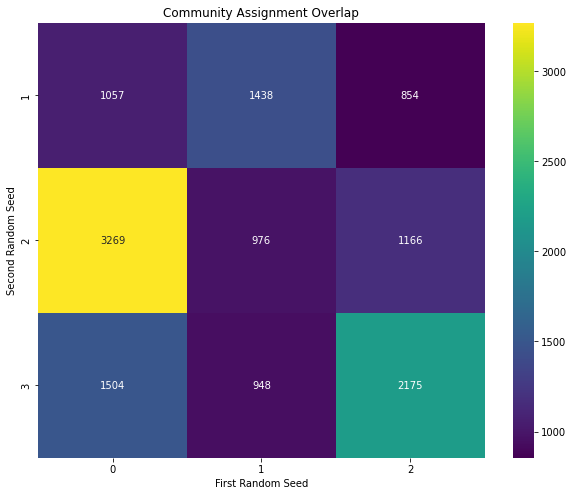

In [113]:
plot_community_overlap(merged_df, partition_df2)

In [117]:
import numpy as np
import pandas as pd

class CommunityAnalysisReport:
    def __init__(self, engine):
        self.engine = engine

    def take_svcid_HF(self):
        # Retrieve all service class IDs
        query_s1 = """ 
            SELECT DISTINCT service_class_id 
            FROM HF.interactions 
            WHERE service_class_id != -1
            """
        return pd.read_sql(query_s1, self.engine)

    def interactionsAndPatientsOFeachSvc_HF(self, df):
        # Get the number of patients per service class in the given dataframe
        patient_ids = df["patient_id"].unique()
        patient_string = ','.join(f"'{pid}'" for pid in patient_ids)

        query_s2 = f""" 
            SELECT service_class_id, 
                   COUNT(DISTINCT patient_id) AS patients,
                   COUNT(*) AS interactions
            FROM HF.interactions 
            WHERE patient_id IN ({patient_string}) 
              AND service_class_id != -1
            GROUP BY service_class_id
            ORDER BY patients DESC
            """

        return pd.read_sql(query_s2, self.engine)

    def safe_division1(self,x, y):
        if y == 0:
            return np.nan
        else:
            return round(((x / y)*100), 2)

    def interactions_and_patients_of_each_svc_HF(self, df):

        take_svcid_label = self.take_svcid_HF()
        i = 0
        for community in df.community_id.unique():
            index = np.where(df.community_id == community)
            community_df = df.iloc[index]
            interactionsAndPatientsOFeachSvc_df = self.interactionsAndPatientsOFeachSvc_HF(community_df)          
            interactionsAndPatientsOFeachSvcMergeWithAllSvc = pd.merge(
                take_svcid_label, 
                interactionsAndPatientsOFeachSvc_df, 
                on='service_class_id', 
                how='left'
            )
            new_patients_col = f"{community}  #patients"
            new_interactions_col = f"{community}  #interactions" 
            col_dict = {'patients': new_patients_col, 'interactions': new_interactions_col}
            interactionsAndPatientsOFeachSvcMergeWithAllSvc = interactionsAndPatientsOFeachSvcMergeWithAllSvc.rename(columns=col_dict)
            interactionsAndPatientsOFeachSvcMergeWithAllSvc = interactionsAndPatientsOFeachSvcMergeWithAllSvc.fillna(0)

            summary = interactionsAndPatientsOFeachSvcMergeWithAllSvc
            summary[f'community%{community}'] = summary.apply(
                lambda row: self.safe_division1(row[new_patients_col], len(community_df)), axis=1
            )

            if i != 0:
                df_copy = pd.merge(df_copy, summary, on='service_class_id', how='left')
            else:  
                df_copy = summary.copy(deep=True)

            i += 1

        result_df_s = df_copy.fillna(0)

        # Fetch service class names
        query = """
                SELECT DISTINCT i.service_class_id, s.service_class_name
                FROM HF.interactions i
                JOIN Ref.service_classifications s ON i.service_class_id = s.service_class_id;
                """
        df_service = pd.read_sql(query, self.engine)

        # Map service_class_id to service_class_name
        result_df_s = result_df_s.merge(df_service, on='service_class_id', how='left')

        # Reorder columns to place service_class_name after service_class_id
        columns = result_df_s.columns.tolist()
        service_class_name = columns.pop(-1)  # Assuming service_class_name is the last column
        columns.insert(1, service_class_name)
        result_df_s = result_df_s[columns]

        return result_df_s

community_report = CommunityAnalysisReport(engine)

# Load your community DataFrame (make sure 'community_id' is a column)
df = pd.read_csv('communities_withoutgraph_before_noptid_without(80,150,152_68).csv')
df.rename(columns={'community_assignment': 'community_id'}, inplace=True)

# Generate the service summary
service = community_report.interactions_and_patients_of_each_svc_HF(df)

# Save to CSV
service.to_csv('Community_scv_afterfall_without(80,150,152,68).csv', index=False)

# Display the result
print(service)


     service_class_id                   service_class_name  1  #patients  \
0                   1        MHSU-Psych Emerg Service - ED          28.0   
1                   2          MHSU-Mobile Crisis Response          44.0   
2                   3          MHSU-Comm Outreach Mod/High           1.0   
3                   4               Seniors Outreach Teams         476.0   
4                   5        MHSU-Acute Care Regular-Adult          24.0   
..                ...                                  ...           ...   
197               293  Rehabilitation-Spasticity-Intensive           8.0   
198               294       MHSU Health & Housing Supports           0.0   
199               295         Acute Care-Disaster-Overflow           2.0   
200               296         MHSU-Infant and Early Yrs MH           0.0   
201               298            MHSU-Eating Disorders-Amb           0.0   

     1  #interactions  community%1  2  #patients  2  #interactions  \
0                

In [118]:
duplicate_patients = df['patient_id'].duplicated().sum()
print(f"Number of duplicate patient IDs: {duplicate_patients}")
patient_counts = df.groupby('community_id')['patient_id'].nunique()
print(patient_counts)

patient_counts.to_csv('patient_counts_after_without(80,150,152_68).csv', index=False)

partition_df.head()

Number of duplicate patient IDs: 0
community_id
0    6091
1    2733
2    4563
Name: patient_id, dtype: int64


,patient_id,community_assignment
0,10001903,2
1,1000582,0
2,1000703,1
3,10012A2,1
4,10015703,1
